In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [47]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ids = test['id']
df = pd.concat([train, test])

In [48]:
df = df.drop(columns = ['id'])

In [49]:
for i in range(4):
    df[f'attribute_{i}'] = df[f'attribute_{i}'].astype('category')

In [50]:
for col in df.select_dtypes(np.number).columns[:-1]:
    df[col] = df[col].fillna(df[col].mean())

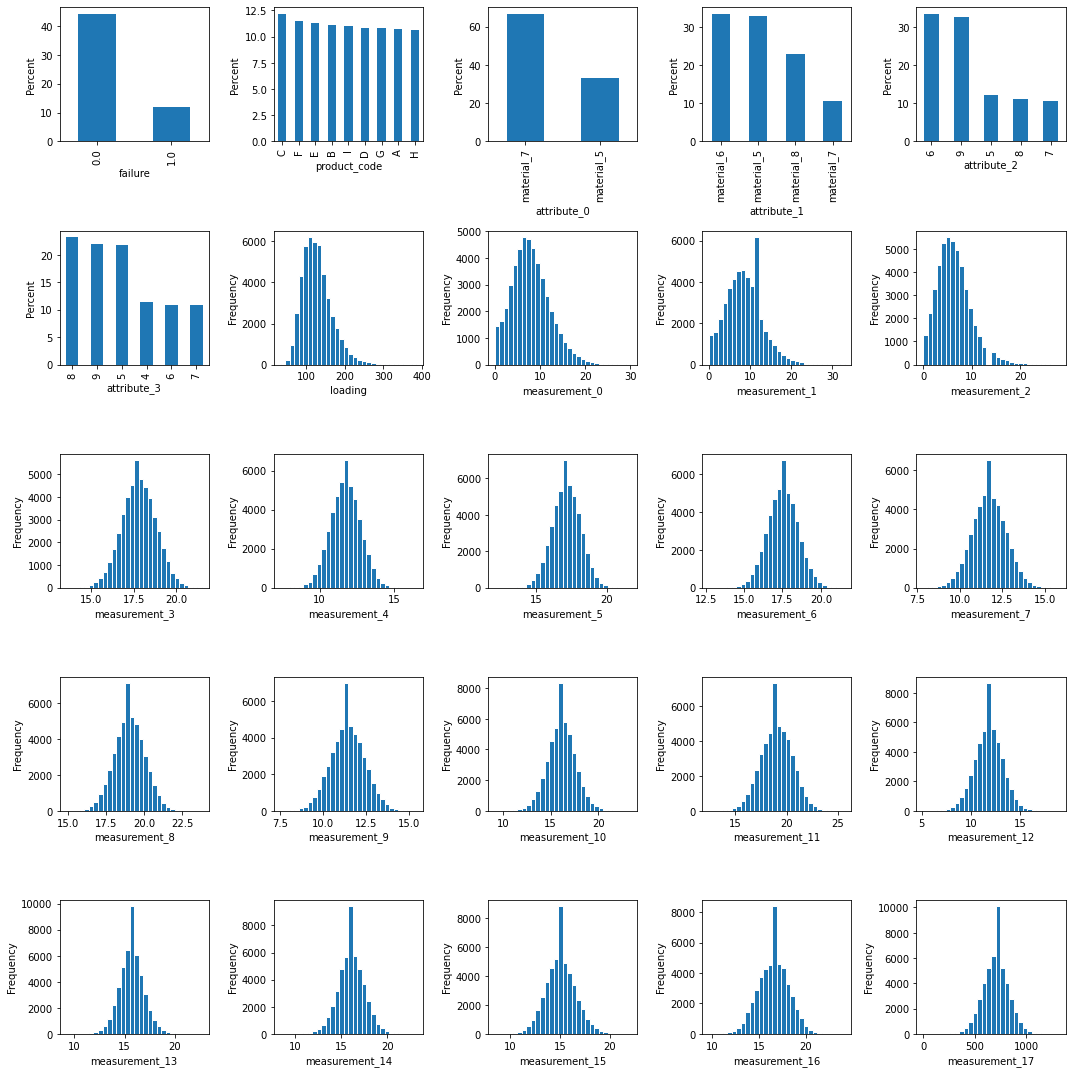

In [51]:
categorical = ['failure', 'product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']
numerical = df.drop(columns = categorical).columns

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(categorical):
    (100* df[col].value_counts() / len(df)).plot.bar(ax = axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percent')
    
for i, col in enumerate(numerical):
    j = i+len(categorical)
    
    df[col].plot.hist(ax = axes[j], bins = 30, edgecolor='white')
    axes[j].set_xlabel(col)
    
plt.tight_layout()

In [52]:
df_dummy = pd.get_dummies(df)

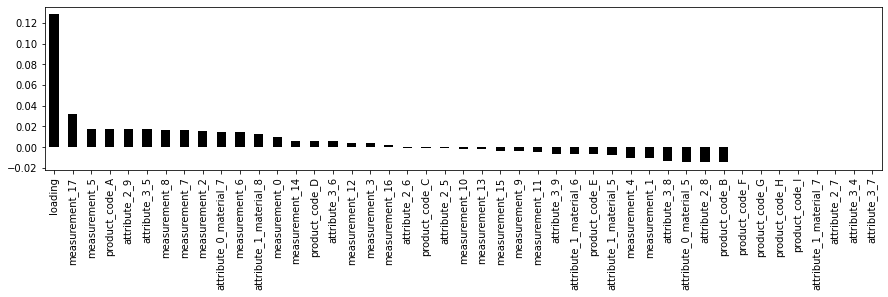

In [53]:
df_dummy.corr()['failure'].sort_values(ascending=False)[1:].plot.bar(figsize=(15,3), cmap='copper')
plt.show()

In [57]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df_dummy.drop(columns='failure')
y = df_dummy['failure']

features = X.columns.values

Scaler = MinMaxScaler()
Scaler.fit(X)
X = Scaler.transform(X)

X = pd.DataFrame(X, columns = features)

X_test = X[len(train):]
X = X.iloc[:len(train)]
y = y.iloc[:len(train)]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [61]:
%%time
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

model_lr = LogisticRegression(max_iter = 800)
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict_proba(X_train)[:, 1]
y_valid_pred = model_lr.predict_proba(X_valid)[:, 1]

print("Training score: ", metrics.roc_auc_score(y_train, y_train_pred))
print("Validation score: ", metrics.roc_auc_score(y_valid, y_valid_pred))

Training score:  0.5930007770697413
Validation score:  0.5926658185788054
CPU times: user 1.38 s, sys: 651 ms, total: 2.04 s
Wall time: 544 ms


In [62]:
%%time
model = XGBClassifier()
model.fit(X_train, y_train)
y_train_pred = model.predict_proba(X_train)[:, 1]
y_valid_pred = model.predict_proba(X_valid)[:, 1]

print("Training score: ", metrics.roc_auc_score(y_train, y_train_pred))
print("Validation score: ", metrics.roc_auc_score(y_valid, y_valid_pred))

Training score:  0.9757866140397357
Validation score:  0.543006038979285
CPU times: user 14 s, sys: 43.3 ms, total: 14 s
Wall time: 3.69 s


In [67]:
final_model = LogisticRegression(max_iter = 800)
final_model.fit(X, y)
print("Training score: ", metrics.roc_auc_score(y, final_model.predict_proba(X)[:, 1]))
y_test_pred = final_model.predict_proba(X_test)[:, -1]

Training score:  0.5937368733463584


In [68]:
output = pd.DataFrame({'id': ids, 'failure': y_test_pred})

In [69]:
output.to_csv("Submission2.csv", index=False)